Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
traj = sample_traj_lorenz(T = 100,speed_up = 4,initial_offset = 10000)

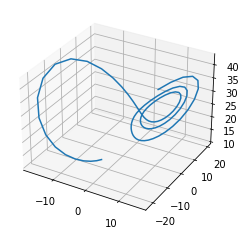

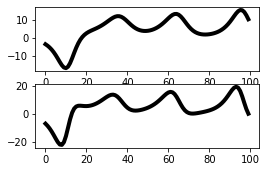

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')

In [4]:
# We sample 20 latent trajectories and project them into 50 output neurons using random weights:

Factor = np.random.randn(3,50)
Time = 100
NRep=1
output = np.zeros((NRep,Time,50))

for i in range(NRep):
    traj = sample_traj_lorenz(T = 100,speed_up = 4,initial_offset = 10000)
    output[i,:,:] = traj @ Factor
    
output = output.astype('float32')

# Z score output:
output=output.reshape(NRep*Time,50)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,50)

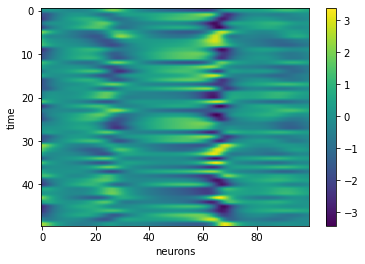

In [5]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('neurons')
plt.ylabel('time')
plt.colorbar()
plt.show()

In [6]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [7]:
tf.keras.backend.clear_session()

In [8]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [9]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


In [10]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 num_factor=3,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        x = self.dense_output(x)
        return x
    

In [11]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 num_factor=3,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [12]:
BATCH_SIZE = 20
batched_dataset = dataset.batch(BATCH_SIZE)

In [13]:

vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=100,
                             num_input_neuron=50,
                             num_factor=3)

# Train Model

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [15]:
KL_penalty = np.linspace(0,1,4)

In [16]:
epochs = 500

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:

                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))


Start of epoch 0
step 0: mean loss = 1.000041
Start of epoch 1
step 0: mean loss = 1.0007904
Start of epoch 2
step 0: mean loss = 0.9997539
Start of epoch 3
step 0: mean loss = 1.0014409
Start of epoch 4
step 0: mean loss = 1.001628
Start of epoch 5
step 0: mean loss = 1.0008172
Start of epoch 6
step 0: mean loss = 1.0004392
Start of epoch 7
step 0: mean loss = 1.0000049
Start of epoch 8
step 0: mean loss = 0.9997842
Start of epoch 9
step 0: mean loss = 0.9993371
Start of epoch 10
step 0: mean loss = 0.9989572
Start of epoch 11
step 0: mean loss = 0.99864453
Start of epoch 12
step 0: mean loss = 0.9983709
Start of epoch 13
step 0: mean loss = 0.99817485
Start of epoch 14
step 0: mean loss = 0.9978616
Start of epoch 15
step 0: mean loss = 0.99755543
Start of epoch 16
step 0: mean loss = 0.9972042
Start of epoch 17
step 0: mean loss = 0.9968783
Start of epoch 18
step 0: mean loss = 0.9965737
Start of epoch 19
step 0: mean loss = 0.9963449
Start of epoch 20
step 0: mean loss = 0.9960785
S

step 0: mean loss = 0.8042933
Start of epoch 169
step 0: mean loss = 0.8040594
Start of epoch 170
step 0: mean loss = 0.8049742
Start of epoch 171
step 0: mean loss = 0.8053767
Start of epoch 172
step 0: mean loss = 0.8046925
Start of epoch 173
step 0: mean loss = 0.8046027
Start of epoch 174
step 0: mean loss = 0.80426234
Start of epoch 175
step 0: mean loss = 0.8035939
Start of epoch 176
step 0: mean loss = 0.8034594
Start of epoch 177
step 0: mean loss = 0.8029508
Start of epoch 178
step 0: mean loss = 0.80237466
Start of epoch 179
step 0: mean loss = 0.8020271
Start of epoch 180
step 0: mean loss = 0.801521
Start of epoch 181
step 0: mean loss = 0.80082846
Start of epoch 182
step 0: mean loss = 0.8002942
Start of epoch 183
step 0: mean loss = 0.7998642
Start of epoch 184
step 0: mean loss = 0.799146
Start of epoch 185
step 0: mean loss = 0.79875964
Start of epoch 186
step 0: mean loss = 0.79830647
Start of epoch 187
step 0: mean loss = 0.79760385
Start of epoch 188
step 0: mean los

step 0: mean loss = 0.7281225
Start of epoch 335
step 0: mean loss = 0.7277938
Start of epoch 336
step 0: mean loss = 0.7274598
Start of epoch 337
step 0: mean loss = 0.72710633
Start of epoch 338
step 0: mean loss = 0.72674197
Start of epoch 339
step 0: mean loss = 0.72637534
Start of epoch 340
step 0: mean loss = 0.7260101
Start of epoch 341
step 0: mean loss = 0.7256444
Start of epoch 342
step 0: mean loss = 0.7252724
Start of epoch 343
step 0: mean loss = 0.72488964
Start of epoch 344
step 0: mean loss = 0.7244951
Start of epoch 345
step 0: mean loss = 0.72409153
Start of epoch 346
step 0: mean loss = 0.72368103
Start of epoch 347
step 0: mean loss = 0.72326636
Start of epoch 348
step 0: mean loss = 0.72285485
Start of epoch 349
step 0: mean loss = 0.7224546
Start of epoch 350
step 0: mean loss = 0.7220924
Start of epoch 351
step 0: mean loss = 0.72172415
Start of epoch 352
step 0: mean loss = 0.7212994
Start of epoch 353
step 0: mean loss = 0.7208153
Start of epoch 354
step 0: mea

step 0: mean loss = 0.56731474
Start of epoch 2
step 0: mean loss = 0.5711815
Start of epoch 3
step 0: mean loss = 0.57166123
Start of epoch 4
step 0: mean loss = 0.5728203
Start of epoch 5
step 0: mean loss = 0.5736523
Start of epoch 6
step 0: mean loss = 0.5752118
Start of epoch 7
step 0: mean loss = 0.5768109
Start of epoch 8
step 0: mean loss = 0.57807565
Start of epoch 9
step 0: mean loss = 0.57835406
Start of epoch 10
step 0: mean loss = 0.57944953
Start of epoch 11
step 0: mean loss = 0.5797816
Start of epoch 12
step 0: mean loss = 0.57956
Start of epoch 13
step 0: mean loss = 0.58085966
Start of epoch 14
step 0: mean loss = 0.58261955
Start of epoch 15
step 0: mean loss = 0.5848465
Start of epoch 16
step 0: mean loss = 0.5866251
Start of epoch 17
step 0: mean loss = 0.5878697
Start of epoch 18
step 0: mean loss = 0.58907557
Start of epoch 19
step 0: mean loss = 0.5901578
Start of epoch 20
step 0: mean loss = 0.59120387
Start of epoch 21
step 0: mean loss = 0.5921281
Start of ep

step 0: mean loss = 0.6749328
Start of epoch 171
step 0: mean loss = 0.67526686
Start of epoch 172
step 0: mean loss = 0.6755959
Start of epoch 173
step 0: mean loss = 0.67593163
Start of epoch 174
step 0: mean loss = 0.6762346
Start of epoch 175
step 0: mean loss = 0.67655516
Start of epoch 176
step 0: mean loss = 0.6768869
Start of epoch 177
step 0: mean loss = 0.67719996
Start of epoch 178
step 0: mean loss = 0.6774949
Start of epoch 179
step 0: mean loss = 0.6777737
Start of epoch 180
step 0: mean loss = 0.6780525
Start of epoch 181
step 0: mean loss = 0.67831624
Start of epoch 182
step 0: mean loss = 0.6786147
Start of epoch 183
step 0: mean loss = 0.67887264
Start of epoch 184
step 0: mean loss = 0.67913526
Start of epoch 185
step 0: mean loss = 0.67939365
Start of epoch 186
step 0: mean loss = 0.67964816
Start of epoch 187
step 0: mean loss = 0.67992705
Start of epoch 188
step 0: mean loss = 0.6801875
Start of epoch 189
step 0: mean loss = 0.68043476
Start of epoch 190
step 0: m

step 0: mean loss = 0.656846
Start of epoch 337
step 0: mean loss = 0.65695375
Start of epoch 338
step 0: mean loss = 0.657184
Start of epoch 339
step 0: mean loss = 0.6573231
Start of epoch 340
step 0: mean loss = 0.65930486
Start of epoch 341
step 0: mean loss = 0.6608274
Start of epoch 342
step 0: mean loss = 0.6659138
Start of epoch 343
step 0: mean loss = 0.6660489
Start of epoch 344
step 0: mean loss = 0.6660975
Start of epoch 345
step 0: mean loss = 0.6661644
Start of epoch 346
step 0: mean loss = 0.6662108
Start of epoch 347
step 0: mean loss = 0.6662313
Start of epoch 348
step 0: mean loss = 0.6662329
Start of epoch 349
step 0: mean loss = 0.66622436
Start of epoch 350
step 0: mean loss = 0.6661063
Start of epoch 351
step 0: mean loss = 0.6660599
Start of epoch 352
step 0: mean loss = 0.6658876
Start of epoch 353
step 0: mean loss = 0.6656572
Start of epoch 354
step 0: mean loss = 0.6654233
Start of epoch 355
step 0: mean loss = 0.66518754
Start of epoch 356
step 0: mean loss 

step 0: mean loss = 0.6417647
Start of epoch 4
step 0: mean loss = 0.642068
Start of epoch 5
step 0: mean loss = 0.6425116
Start of epoch 6
step 0: mean loss = 0.643268
Start of epoch 7
step 0: mean loss = 0.6437147
Start of epoch 8
step 0: mean loss = 0.64393085
Start of epoch 9
step 0: mean loss = 0.64422125
Start of epoch 10
step 0: mean loss = 0.6443738
Start of epoch 11
step 0: mean loss = 0.6443815
Start of epoch 12
step 0: mean loss = 0.6442618
Start of epoch 13
step 0: mean loss = 0.6440669
Start of epoch 14
step 0: mean loss = 0.6439094
Start of epoch 15
step 0: mean loss = 0.6436787
Start of epoch 16
step 0: mean loss = 0.6433681
Start of epoch 17
step 0: mean loss = 0.6430984
Start of epoch 18
step 0: mean loss = 0.6428306
Start of epoch 19
step 0: mean loss = 0.6425652
Start of epoch 20
step 0: mean loss = 0.64230186
Start of epoch 21
step 0: mean loss = 0.64239806
Start of epoch 22
step 0: mean loss = 0.64205945
Start of epoch 23
step 0: mean loss = 0.64183503
Start of epo

step 0: mean loss = 0.6439098
Start of epoch 173
step 0: mean loss = 0.6437239
Start of epoch 174
step 0: mean loss = 0.64339054
Start of epoch 175
step 0: mean loss = 0.6430634
Start of epoch 176
step 0: mean loss = 0.6427276
Start of epoch 177
step 0: mean loss = 0.64240646
Start of epoch 178
step 0: mean loss = 0.64201266
Start of epoch 179
step 0: mean loss = 0.641664
Start of epoch 180
step 0: mean loss = 0.6412772
Start of epoch 181
step 0: mean loss = 0.64095634
Start of epoch 182
step 0: mean loss = 0.64088035
Start of epoch 183
step 0: mean loss = 0.64053446
Start of epoch 184
step 0: mean loss = 0.6401894
Start of epoch 185
step 0: mean loss = 0.6399043
Start of epoch 186
step 0: mean loss = 0.63961613
Start of epoch 187
step 0: mean loss = 0.63933575
Start of epoch 188
step 0: mean loss = 0.63906497
Start of epoch 189
step 0: mean loss = 0.6387703
Start of epoch 190
step 0: mean loss = 0.6384703
Start of epoch 191
step 0: mean loss = 0.6381671
Start of epoch 192
step 0: mean

step 0: mean loss = 0.607415
Start of epoch 339
step 0: mean loss = 0.6070352
Start of epoch 340
step 0: mean loss = 0.60664797
Start of epoch 341
step 0: mean loss = 0.6063333
Start of epoch 342
step 0: mean loss = 0.60603464
Start of epoch 343
step 0: mean loss = 0.6058194
Start of epoch 344
step 0: mean loss = 0.6059115
Start of epoch 345
step 0: mean loss = 0.60557157
Start of epoch 346
step 0: mean loss = 0.6052661
Start of epoch 347
step 0: mean loss = 0.60493
Start of epoch 348
step 0: mean loss = 0.6046382
Start of epoch 349
step 0: mean loss = 0.6044784
Start of epoch 350
step 0: mean loss = 0.6042476
Start of epoch 351
step 0: mean loss = 0.60397965
Start of epoch 352
step 0: mean loss = 0.60374177
Start of epoch 353
step 0: mean loss = 0.6035925
Start of epoch 354
step 0: mean loss = 0.60332763
Start of epoch 355
step 0: mean loss = 0.60308725
Start of epoch 356
step 0: mean loss = 0.60279244
Start of epoch 357
step 0: mean loss = 0.60256445
Start of epoch 358
step 0: mean l

step 0: mean loss = 0.56007475
Start of epoch 6
step 0: mean loss = 0.5598151
Start of epoch 7
step 0: mean loss = 0.55953825
Start of epoch 8
step 0: mean loss = 0.55921656
Start of epoch 9
step 0: mean loss = 0.5589293
Start of epoch 10
step 0: mean loss = 0.5586467
Start of epoch 11
step 0: mean loss = 0.55832154
Start of epoch 12
step 0: mean loss = 0.557996
Start of epoch 13
step 0: mean loss = 0.5576719
Start of epoch 14
step 0: mean loss = 0.55734885
Start of epoch 15
step 0: mean loss = 0.5570121
Start of epoch 16
step 0: mean loss = 0.5566926
Start of epoch 17
step 0: mean loss = 0.5581259
Start of epoch 18
step 0: mean loss = 0.55780476
Start of epoch 19
step 0: mean loss = 0.5575572
Start of epoch 20
step 0: mean loss = 0.5573312
Start of epoch 21
step 0: mean loss = 0.5572817
Start of epoch 22
step 0: mean loss = 0.55713505
Start of epoch 23
step 0: mean loss = 0.5570092
Start of epoch 24
step 0: mean loss = 0.5568947
Start of epoch 25
step 0: mean loss = 0.55669975
Start o

step 0: mean loss = 0.54189056
Start of epoch 174
step 0: mean loss = 0.5419157
Start of epoch 175
step 0: mean loss = 0.5419688
Start of epoch 176
step 0: mean loss = 0.5419242
Start of epoch 177
step 0: mean loss = 0.54183275
Start of epoch 178
step 0: mean loss = 0.54173875
Start of epoch 179
step 0: mean loss = 0.54165417
Start of epoch 180
step 0: mean loss = 0.5414787
Start of epoch 181
step 0: mean loss = 0.541299
Start of epoch 182
step 0: mean loss = 0.54114693
Start of epoch 183
step 0: mean loss = 0.54097164
Start of epoch 184
step 0: mean loss = 0.54081416
Start of epoch 185
step 0: mean loss = 0.54083407
Start of epoch 186
step 0: mean loss = 0.5407224
Start of epoch 187
step 0: mean loss = 0.5406999
Start of epoch 188
step 0: mean loss = 0.5405966
Start of epoch 189
step 0: mean loss = 0.5405205
Start of epoch 190
step 0: mean loss = 0.5404635
Start of epoch 191
step 0: mean loss = 0.54038584
Start of epoch 192
step 0: mean loss = 0.540257
Start of epoch 193
step 0: mean 

step 0: mean loss = 0.5238308
Start of epoch 341
step 0: mean loss = 0.52370834
Start of epoch 342
step 0: mean loss = 0.52354664
Start of epoch 343
step 0: mean loss = 0.5233432
Start of epoch 344
step 0: mean loss = 0.5231057
Start of epoch 345
step 0: mean loss = 0.5229226
Start of epoch 346
step 0: mean loss = 0.52269113
Start of epoch 347
step 0: mean loss = 0.522463
Start of epoch 348
step 0: mean loss = 0.52223444
Start of epoch 349
step 0: mean loss = 0.5220099
Start of epoch 350
step 0: mean loss = 0.5217856
Start of epoch 351
step 0: mean loss = 0.5215529
Start of epoch 352
step 0: mean loss = 0.5213129
Start of epoch 353
step 0: mean loss = 0.5210727
Start of epoch 354
step 0: mean loss = 0.52082807
Start of epoch 355
step 0: mean loss = 0.52058357
Start of epoch 356
step 0: mean loss = 0.52033603
Start of epoch 357
step 0: mean loss = 0.52141774
Start of epoch 358
step 0: mean loss = 0.5211827
Start of epoch 359
step 0: mean loss = 0.5209356
Start of epoch 360
step 0: mean 

# Evaluate Quality of reconstruction 

(1, 100, 50)


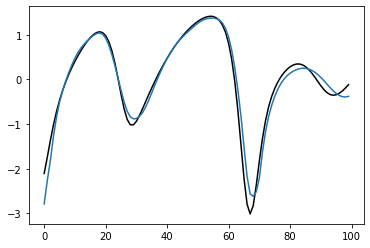

In [22]:
for x in batched_dataset.take(1):
    print(x.shape)
    for i in range(x.shape[0]):
        plt.figure()
        plt.plot(x[i,:,40],'k')
        x_hat = vae(x)
        plt.plot(x_hat[i,:,40])
